In [1]:
import SOAP
from SOAP import PHOENIX,Spec_mu
from SOAP.fast_starspot import doppler_shift
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.colors import Normalize, LinearSegmentedColormap, TwoSlopeNorm
from ldtk import LDPSetCreator, BoxcarFilter

In [2]:
transgrad = LinearSegmentedColormap.from_list('Random gradient 9491', (
    # Edit this gradient at https://eltos.github.io/gradient/#Random%20gradient%209491=008080-FFF2F2-440154
    (0.000, (1.000, 0.000, 0.000)),  # Bright red (#FF0000) at the low end
    (0.500, (1.000, 1.000, 1.000)),  # Bright gray (white) at the middle
    (1.000, (0.000, 0.000, 0.545))))

# Transmission spectrum of a transit event

# Define the system properties (HD209458)

In [3]:
#Star
radius=1    # Solar Radii
mass=1      # Solar mass
prot=24.47
incl=90         # Inclination of the stellar rotation axis relative to the sky-plane
diffrotB=0      # Differential roation coeff
diffrotC=0      # Differential roation coeff
logg= 4.4
logg_sig=0.001
feh= 0.00
feh_sig= 0.01
Teff=5777
Teff_sig=10

#Planet
start_psi=0.0
Pp=3.13   # Orbital period in days
e=0.0           # Orbital eccentricity
w=90.0          # Argument of periastron
ip=90        # Orbital inclination
lbda=0       # Sky-projected spin-orbit misalignement
a=9          # Semi-major axis
Rp= 0.15      # Planetary radius in stellar radii
Mp= 317.8       # Planetary mass in Earth masses

In [4]:
λ = (5882, 5902)

In [5]:
filters = [BoxcarFilter('filter',λ[0]/10, λ[1]/10)] #expresso spectograph bandpass 380, 788nm
sc = LDPSetCreator(teff=(Teff, 43),    # parametros da estrela
logg=(logg,logg_sig),
 z=(feh, feh_sig),
filters=filters)
ps = sc.create_profiles()      	         # Create the limb darkening profiles
ldcn, qe = ps.coeffs_qd(do_mc=True) #coeficientes e os seus erros de perfil quadrático

Where we use will import Phoenix spectra that match the stellar properties. These will be used to compute the RVs in the simulation

In [6]:
spQt = PHOENIX(wave_range=λ, normalize=True, teff=Teff, logg=logg, Z=0)
tplt={"wave":spQt.wave, "flux":spQt.flux}

In [7]:
spQ=spQt

# Start the simulation

In [8]:
sim = SOAP.Simulation( pixel=spQ, pixel_spot=None, wlll=(λ[1]+λ[0])/2, inst_reso=140000, grid=600, active_regions=[], ring=None)

In [9]:
# Set the properties of the star and planet
sim.star.set(prot=prot,incl=incl,diffrotB=diffrotB,diffrotC=diffrotC,u1=ldcn[0][0],u2= ldcn[0][1], start_psi=start_psi,radius=radius,mass=mass,teff=Teff)
sim.planet.set(P=Pp,t0=start_psi,e=e,w=w,ip=ip,lbda=lbda,a=a,Rp=Rp,Mp=Mp)

In [10]:
# Check the properties
print(sim.star)
print(sim.planet)


SOAP.Star(prot=24.47 d; incl=90.0 deg; radius=1.0 solRad; teff=5777 K)
SOAP.Planet(P=3.13 d; t0=0.0 d; e=0.0; w=90.0 deg; ip=90.0 deg; lbda=0.0 deg; a=9.0 solRad, Rp=0.15 solRad)


In [11]:
# Provide the phases normalized by the stellar rotation
psi = np.linspace(-0.1,0.1,50) / sim.star.prot

In [12]:
out=sim.calculate_signal(psi, renormalize_rv=True, template=tplt)


In [13]:
absorption_spec=(1-sim.pixel_trans)*100

In [14]:
tr_dur=1./np.pi * np.arcsin(1./a *np.sqrt((1+Rp )**2.-a**2. *np.cos(np.radians(ip))**2.))
tr_ingress_egress=1./np.pi * np.arcsin(1./a *np.sqrt((1.-Rp)**2.-a**2. *np.cos(np.radians(ip))**2.))

In [15]:
psi_planet=(psi*sim.star.prot/sim.planet.P).value

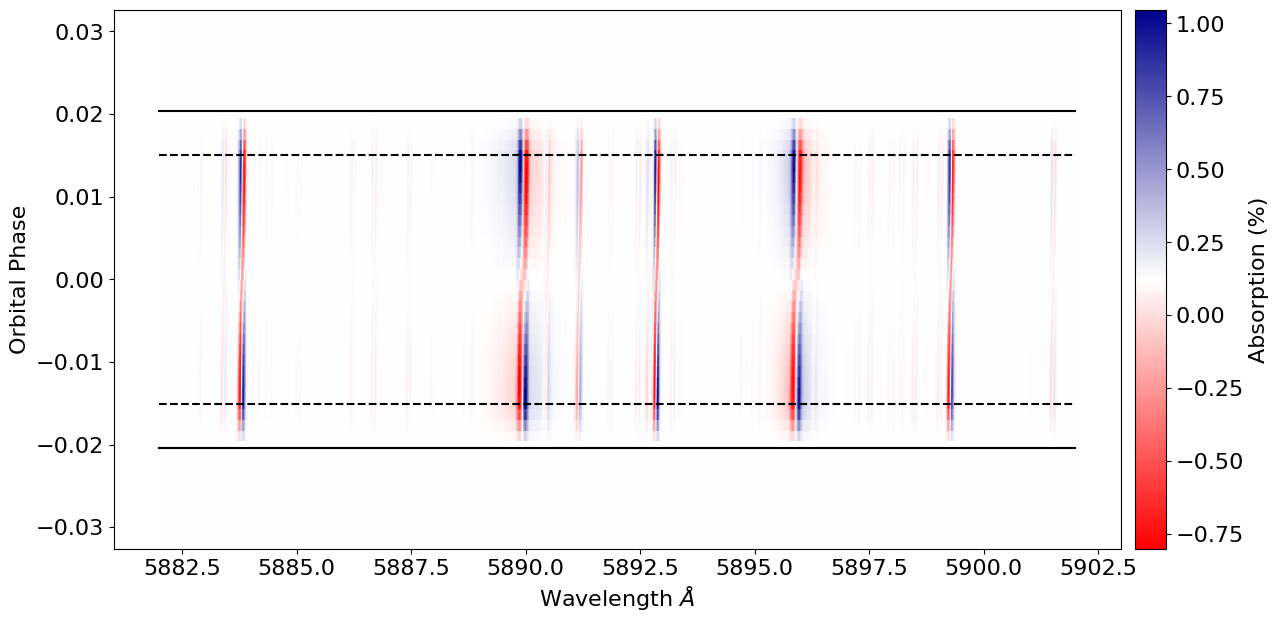

In [16]:
X,Y=np.meshgrid(sim.pixel.wave,psi_planet)
fig, ax = plt.subplots(figsize=(13,7))

norm = TwoSlopeNorm(vmin=np.min(absorption_spec), vcenter=0, vmax=np.max(absorption_spec))  # Center at zero
im=ax.pcolor(X,Y,absorption_spec, cmap=transgrad, norm=norm)
ax.set_xlabel("Wavelength "+r"$\AA$")
ax.set_ylabel("Orbital Phase")


plt.plot(λ, [-tr_dur/2, -tr_dur/2], '-k')
plt.plot(λ, [tr_dur/2, tr_dur/2], '-k')
plt.plot(λ, [-tr_ingress_egress/2, -tr_ingress_egress/2], '--k')
plt.plot(λ, [tr_ingress_egress/2, tr_ingress_egress/2], '--k')

sm = ScalarMappable(cmap=im.get_cmap())
sm.set_clim(np.min(absorption_spec), np.max(absorption_spec))

sm.set_array([])  # Set an empty array (required)
fig = plt.gcf()

# Get the position of the main image axes
image_position = im.axes.get_position()

# Create the colorbar axes with a slightly smaller width for spacing
colorbard_width = image_position.width * 0.03  # Adjust width as needed
ax = fig.add_axes([image_position.x1+0.011, image_position.y0, colorbard_width, image_position.height])
fig.colorbar(sm, cax=ax, label="Absorption (%)")  # Add a label

In [17]:
from astropy.constants import M_earth, M_sun

In [18]:
Kp=(sim.planet.K)*(M_sun*sim.star.mass)/(sim.planet.Mp*(M_earth))
pshift=(Kp*np.sin(2*np.pi*psi_planet)).value


In [19]:
absorpt_prest=np.array([doppler_shift(sim.pixel.wave,absorption_spec[x],-1000*pshift[x]) for x in range(len(pshift))])

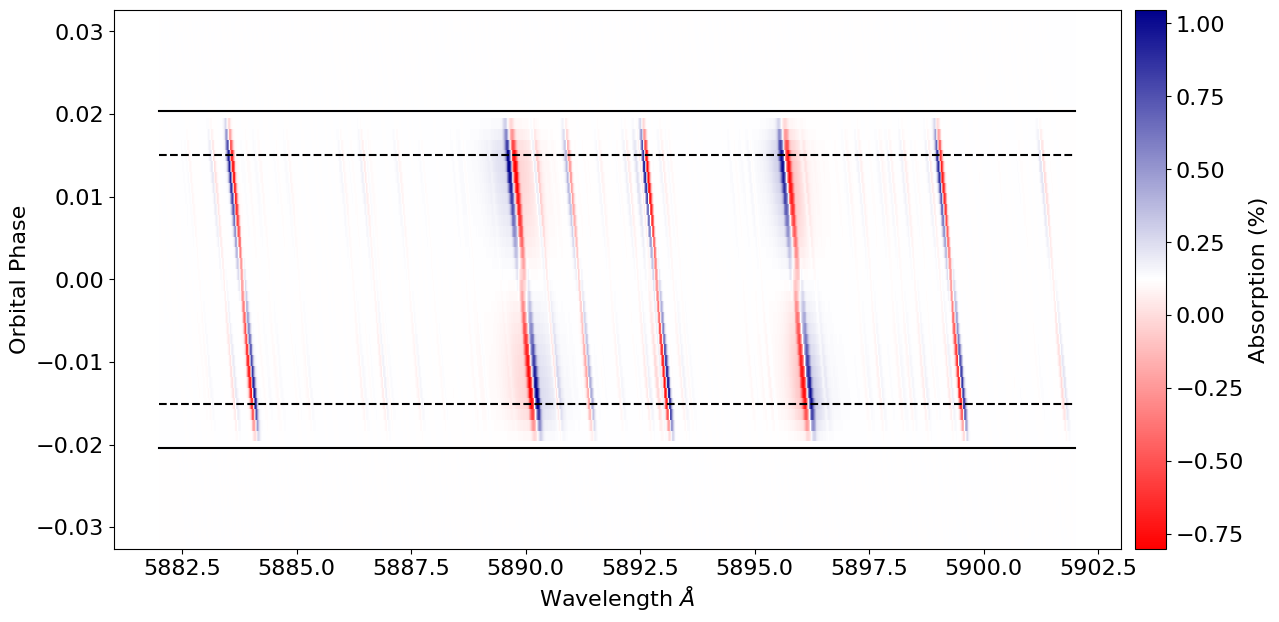

In [20]:
X,Y=np.meshgrid(sim.pixel.wave,psi_planet)
fig, ax = plt.subplots(figsize=(13,7))

norm = TwoSlopeNorm(vmin=np.min(absorpt_prest), vcenter=0, vmax=np.max(absorpt_prest))  # Center at zero
im=ax.pcolor(X,Y,absorpt_prest, cmap=transgrad, norm=norm)
ax.set_xlabel("Wavelength "+r"$\AA$")
ax.set_ylabel("Orbital Phase")


plt.plot(λ, [-tr_dur/2, -tr_dur/2], '-k')
plt.plot(λ, [tr_dur/2, tr_dur/2], '-k')
plt.plot(λ, [-tr_ingress_egress/2, -tr_ingress_egress/2], '--k')
plt.plot(λ, [tr_ingress_egress/2, tr_ingress_egress/2], '--k')

sm = ScalarMappable(cmap=im.get_cmap())
sm.set_clim(np.min(absorption_spec), np.max(absorption_spec))

sm.set_array([])  # Set an empty array (required)
fig = plt.gcf()

# Get the position of the main image axes
image_position = im.axes.get_position()

# Create the colorbar axes with a slightly smaller width for spacing
colorbard_width = image_position.width * 0.03  # Adjust width as needed
ax = fig.add_axes([image_position.x1+0.011, image_position.y0, colorbard_width, image_position.height])
fig.colorbar(sm, cax=ax, label="Absorption (%)")  # Add a label

In [21]:
mask_T2_T3 = np.logical_and(psi_planet> -tr_ingress_egress / 2, psi_planet< tr_ingress_egress / 2)
mask_T1_T4 = np.logical_and(psi_planet> -tr_dur / 2, psi_planet< tr_dur / 2)

In [22]:
mean_T2_T3=np.mean(absorpt_prest[mask_T2_T3], axis=0)
mean_T1_T4=np.mean(absorpt_prest[mask_T1_T4], axis=0)

Text(0, 0.5, 'Absorption (%)')

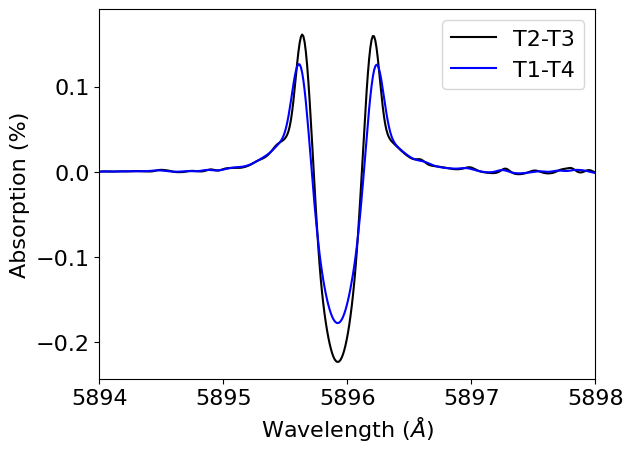

In [23]:
plt.plot(sim.pixel.wave,mean_T2_T3,"k", label="T2-T3")
plt.plot(sim.pixel.wave,mean_T1_T4,"b", label="T1-T4")
plt.legend()
plt.xlim(5894,5898)
plt.xlabel("Wavelength ("+r"$\AA$)")
plt.ylabel("Absorption (%)")

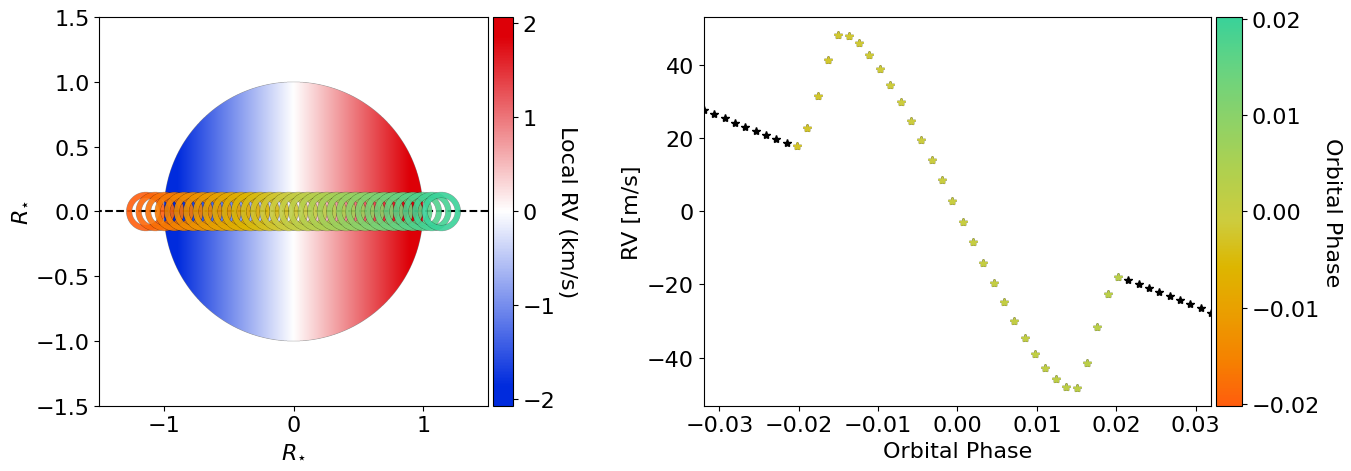

In [24]:
sim.visualize(output=out,plot_type="rv")